# Predict Student Performance from Game Play 🎼

## Description 📝

The DS project is the Kaggle competition

https://www.kaggle.com/competitions/predict-student-performance-from-game-play/overview

**Goal**: to predict student perfomance during game-based learning in real-time.

- **DS problem type**: binary classification, tabular data.

- **Data type**: game logs (time series).

- **Submission**:

session_id / question number - binary label (correct/incorrect).

*Example*:

session_id,correct

20090109393214576_q1,0

20090312143683264_q1,0

20090312331414616_q1,0

- **Evaluation**: F1-score
$$
F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}
$$

### Dataset description

3 checkpoints:
- 📌 level 4
- 📌 level 12
- 📌 level 22

At each checkpoint we have access to all previous test data.

**18** questions for each sessions.

**Data format**:<br>
rows:<br>
`session_id`_`question #`

18 rows (questions) for each session

**To predict correctness of each segment**:

3 segments:
- 📌 0-4
- 📌 5-12
- 📌 13-22

#### Files

- `train.csv` - the training set
- `test.csv` - the test set
- `sample_submission.csv` - a sample submission file in the correct format
- `train_labels.csv` - correct value for all 18 questions for each session in the training set

#### Columns

- `session_id` - the ID of the session the event took place in
- `index` - the index of the event for the session
- `elapsed_time` - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
- `event_name` - the name of the event type
- `name` - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
- `level` - what level of the game the event occurred in (0 to 22)
- `page` - the page number of the event (only for notebook-related events)
- `room_coor_x` - the coordinates of the click in reference to the in-game room (only for click events)
- `room_coor_y` - the coordinates of the click in reference to the in-game room (only for click events)
- `screen_coor_x` - the coordinates of the click in reference to the player’s screen (only for click events)
- `screen_coor_y` - the coordinates of the click in reference to the player’s screen (only for click events)
- `hover_duration` - how long (in milliseconds) the hover happened for (only for hover events)
- `text` - the text the player sees during this event
- `fqid` - the fully qualified ID of the event
- `room_fqid` - the fully qualified ID of the room the event took place in
- `text_fqid` - the fully qualified ID of the text
- `fullscreen` - whether the player is in fullscreen mode
- `hq` - whether the game is in high-quality
- `music` - whether the game music is on or off
- `level_group` - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)


### Credit to the notebooks 🙏
- [Nice EDA](https://www.kaggle.com/code/mvvppp/eda-adventure-navigating-the-children-learning)
- [Idea of reduce memory usage](https://www.kaggle.com/code/mohammad2012191/reduce-memory-usage-2gb-780mb)

## Download the dataset from Kaggle 🔽

In [15]:
#!chmod 600 /Users/kuzmatsukanov/.kaggle/kaggle.json

# Download
#!kaggle competitions download -c predict-student-performance-from-game-play -p ./dataset

# Unzip
#!unzip dataset/predict-student-performance-from-game-play.zip -d ./dataset

## Import libraries and useful functions 📚

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("colorblind"))
from sklearn.metrics import f1_score
from tqdm import tqdm

In [44]:
def reduce_memory_usage_dataframe(df, col_to_skip=[]):
    """
    Reduces memory usage of the given dataframe by optimizing dtypes
    """
    COEF_B_TO_GB = 1024**3

    print('Memory usage before: {:.3f} GB'.format(df_train.memory_usage().sum() / COEF_B_TO_GB))
    
    for col in tqdm(df.columns.drop(labels=col_to_skip)):
        # Get data type of the column
        col_type = df[col].dtype
        
        # Handle integer type
        if col_type == np.int_:
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            else:
                continue
                
        # Handle float type
        elif col_type == np.float_:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
                
        # Handle the categorical types     
        else:
            df_train[col] = df_train[col].astype('category')
    print('Memory usage after: {:.3f} GB'.format(df_train.memory_usage().sum() / COEF_B_TO_GB))
    return df

## Load data 📀

In [11]:
df_labels = pd.read_csv('dataset/train_labels.csv')
df_train = pd.read_csv('dataset/train.csv')

### Parse session_id and # question

In [45]:
# Split session_id column into num_session and num_question columns
df_labels[['num_session', 'num_question']] = df_labels['session_id'].str.split('_', n=1, expand=True)

# Turn into int
df_labels['num_session'] = df_labels['num_session'].astype(int)

# Drop 'q' and turn to int
df_labels['num_question'] = df_labels['num_question'].str[1:].astype(int)

# Reorder columns
df_labels = df_labels[['session_id', 'num_session', 'num_question', 'correct']]

## Exploratory Data Analysis 👨‍🔬

In [276]:
df_train

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26296941,22100221145014656,1600,5483231,navigate_click,undefined,22,NaN,343.887291,36.701026,483.0,273.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,0,0,1,2
26296942,22100221145014656,1601,5485166,navigate_click,undefined,22,NaN,332.696070,141.493178,545.0,221.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,2
26296943,22100221145014656,1602,5485917,navigate_click,undefined,22,NaN,369.912859,140.569205,611.0,217.0,NaN,NaN,NaN,tunic.capitol_2.hall,NaN,0,0,1,2
26296944,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299653,123.805889,526.0,232.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,2


### Reduce memory usage 🦕

In [19]:
df_train = reduce_memory_usage_dataframe(df_train)

Memory usage before: 3.674


100%|██████████████████████████████████████████████████████████████████████████| 20/20 [00:57<00:00,  2.86s/it]

Memory usage after: 1.119


In [48]:
df_labels = reduce_memory_usage_dataframe(df_labels, col_to_skip='correct')

Memory usage before: 1.119 GB


100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16it/s]

Memory usage after: 0.973 GB


In [56]:
df_labels = df_labels.drop(labels=['session_id'], axis=1)

### Data integrity

- There is no missing values in target variables.
- Each session includes 18 questions.
- The questions are numbered between 1 and 18
- All session id are identical for dataset and target variables.

In [206]:
# Each session includes 18 questions. All questions are numbered uniquely
assert df_labels['num_session'].value_counts().unique()[0] == 18

In [207]:
# The questions are numbered between 1 and 18
assert df_labels['num_question'].min() == 1
assert df_labels['num_question'].max() == 18

In [218]:
# All session id are identical for dataset and target variables.
assert set(df_labels['num_session'].values) == set(df_train['session_id'].values)

### Overall characterization

In [246]:
print('In train set')
print('Number of samples (sessions): {}'.format(df_labels['num_session'].nunique()))
print('Number of records: {}'.format(df_train.shape[0]))
print('Number of features: {}'.format(df_train.shape[1]))
print('Number of labeled data: {}'.format(df_labels.shape[0]))

In train set
Number of records: 26296946
Number of features: 20
Number of labeled data: 424116


Number of samples (sessions): 23562


### Number of events per session

In [69]:
num_of_events_per_session = df_train['session_id'].value_counts().values

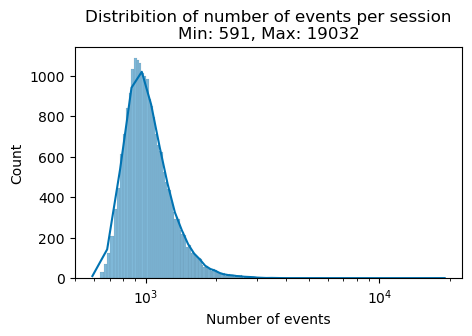

In [90]:
fig, ax = plt.subplots(figsize=(5, 3))

sns.histplot(data=num_of_events_per_session, kde=True, ax=ax)
ax.set_xscale('log')
ax.set_xlabel('Number of events')
ax.set_ylabel('Count')
ax.set_title('Distribition of number of events per session\nMin: {}, Max: {}'.\
             format(num_of_events_per_session.min(),
                    num_of_events_per_session.max()));

### One random session

Let's look at one random session

In [26]:
np.random.seed(0)
random_session_id = df_train.iloc[np.random.randint(0, df_train.shape[0])]['session_id']
df_one_session = df_train[df_train['session_id'] == random_session_id]

In [27]:
print('Number of events (rows): {}'.format(df_one_session.shape[0]))

Number of events (rows): 981


#### Plots

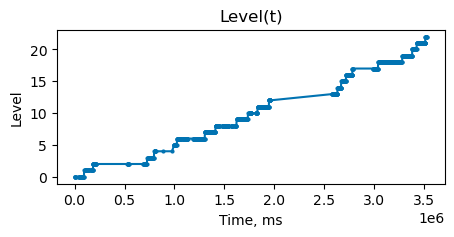

In [28]:
fig, ax = plt.subplots(figsize=(5, 2))

ax.plot(df_one_session['elapsed_time'], df_one_session['level'], marker='o', markersize=2)
ax.set_xlabel('Time, ms')
ax.set_ylabel('Level')
ax.set_title('Level(t)');

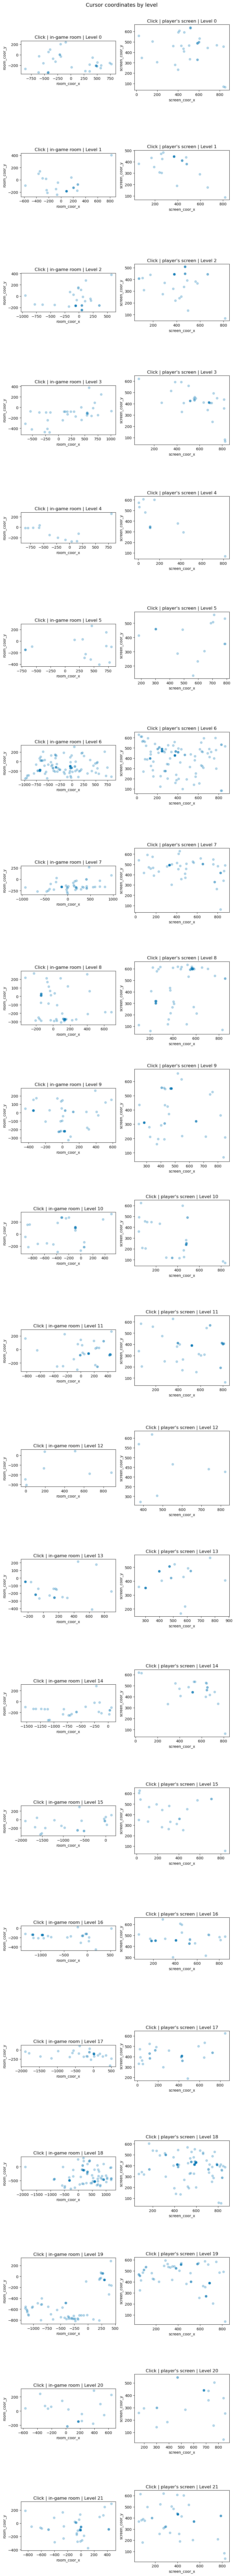

In [29]:
MARKERSIZE = 30
ALPHA = 0.3

fig, ax = plt.subplots(22, 2, figsize=(2*5, 22*5))

for level, axis in zip(np.arange(0, 22), ax):
    level_to_plot = df_one_session[df_one_session['level'] == level]
    axis[0].scatter(x=level_to_plot['room_coor_x'], y=level_to_plot['room_coor_y'],
                    s=MARKERSIZE, alpha=ALPHA)
    axis[0].set_aspect(aspect='equal')
    axis[0].set_xlabel('room_coor_x')
    axis[0].set_ylabel('room_coor_y')
    axis[0].set_title('Click | in-game room | Level {}'.format(level))
    
    axis[1].scatter(x=level_to_plot['screen_coor_x'], y=level_to_plot['screen_coor_y'],
                    s=MARKERSIZE, alpha=ALPHA)
    axis[1].set_aspect(aspect='equal')
    axis[1].set_xlabel('screen_coor_x')
    axis[1].set_ylabel('screen_coor_y')
    axis[1].set_title('Click | player\'s screen | Level {}'.format(level))
    #break
fig.suptitle('Cursor coordinates by level', fontsize=14)
plt.subplots_adjust(top=0.978);

In [363]:
df_one_session

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
8325060,21020114163275160,0,0,cutscene_click,basic,0,NaN,-393.991405,100.685314,400.0,234.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0
8325061,21020114163275160,1,3333,person_click,basic,0,NaN,-207.991405,5.685314,586.0,329.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0
8325062,21020114163275160,2,3911,person_click,basic,0,NaN,-207.991405,5.685314,586.0,329.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0
8325063,21020114163275160,3,6576,person_click,basic,0,NaN,-422.991405,55.685314,371.0,279.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0
8325064,21020114163275160,4,8673,person_click,basic,0,NaN,-289.991405,-130.314686,504.0,465.0,NaN,Ugh. Meetings are so boring.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8326036,21020114163275160,1014,3524759,navigate_click,undefined,22,NaN,942.908310,58.689281,764.0,272.0,NaN,NaN,tomap,tunic.historicalsociety.entry,NaN,0,0,1,2
8326037,21020114163275160,1015,3526641,map_hover,basic,22,NaN,NaN,NaN,NaN,NaN,300.0,NaN,tunic.drycleaner,tunic.historicalsociety.entry,NaN,0,0,1,2
8326038,21020114163275160,1016,3527090,map_click,undefined,22,NaN,526.946690,66.689368,483.0,288.0,NaN,NaN,tunic.capitol_2,tunic.historicalsociety.entry,NaN,0,0,1,2
8326039,21020114163275160,1017,3529688,navigate_click,undefined,22,NaN,187.826685,60.943450,380.0,257.0,NaN,NaN,chap4_finale_c,tunic.capitol_2.hall,NaN,0,0,1,2


### Missing values

#### Target variable

In [202]:
# No missing values in the target variable
assert not df_labels.isna().any().any()

#### Independent variables

In [42]:
count_missing_values = df_train.isna().sum()
count_missing_values = count_missing_values/df_train.shape[0]

In [76]:
count_missing_values_df = pd.DataFrame(count_missing_values[count_missing_values != 0].sort_values(ascending=True),
                                     columns=['Missing values']).round(2)

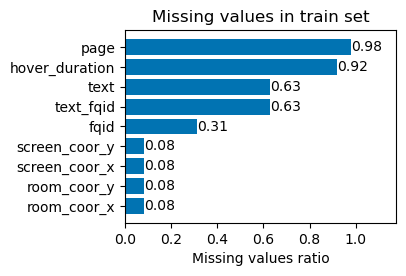

In [114]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

bars = ax.barh(y=count_missing_values_df.index, width=count_missing_values_df['Missing values'])
ax.bar_label(container=bars, padding=0.1)
ax.margins(x=0.2)
ax.set_xlabel('Missing values ratio')
ax.set_title('Missing values in train set');

## Feature engineering 👨‍🔧

In [273]:
# Map the Level group to Int
df_train['level_group'] = df_train['level_group'].map({'0-4': 0, '5-12': 1, '13-22': 2}).astype('int8')

# Check if level_group has relevant values
assert set(df_train['level_group'].unique()) == {0, 1, 2}

In [150]:
df_train.columns

Index(['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'fullscreen', 'hq', 'music', 'level_group'],
      dtype='object')

In [151]:
level0_df = df_train[df_train['level'] == 0][['screen_coor_x', 'screen_coor_y']]

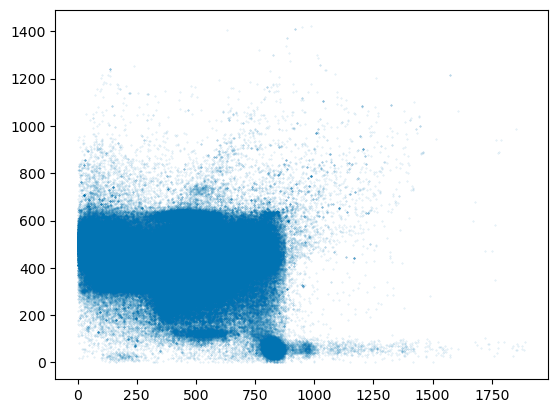

In [157]:
fig, ax = plt.subplots()

ax.scatter(x=level0_df['screen_coor_x'], y=level0_df['screen_coor_y'], s=0.1, alpha=0.2)
ax.set_aspect(aspect='equal');

## Baseline model 🌅

In [233]:
df_labels['correct'].value_counts(normalize=True)

1    0.705635
0    0.294365
Name: correct, dtype: float64

Baseline model is determined by the majority class `1`, i.e. all answers are correct.

Calculate F1-score for the baseline model the training set:

In [240]:
# F1 score for the training set
f1_score(y_true=df_labels['correct'].values,
         y_pred=np.ones(shape=df_labels.shape[0], dtype=int))

0.8274160304235493